# ECS calculation

In [1]:
# load packages
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from scipy import stats
from data import anomaly
import ols,glob
from collections import namedtuple

In [2]:
printf=False # set to true to write out plot files

In [3]:
## make plots pretty
def colorplot(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
        
    for spx in ['bottom','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

def colorplotRight(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','left']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('right')
    ax.xaxis.set_ticks_position('bottom')
    
    # set axis positions
#     ax.yaxis.set_label_position(pspines[0]) 
#     ax.xaxis.set_label_position(pspines[1]) 
    
    for spx in ['bottom','right']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)
    
    ax.yaxis.set_label_position('right')

In [4]:
## monte carlo calculations
numRuns=25000 # number of runs of the monte carlo calculation
print('number of runs in Monte Carlo calculations: {:,}'.format(numRuns))

number of runs in Monte Carlo calculations: 25,000


In [5]:
def monteCarlo1(x1,y1,runs=10000,autocorr=False):
    """x1 and y1 are the input arrays, runs is the number of times to do the calculation,
    returns list of slopes
    if autocorr is True, then the number of samples is reduced; it is set equal to the 
    effective number of degrees of freedom, per Santer et al. 2000
    """

    # calculate neff; effective number of independent samples
    # follows Santer et al. 2000
    lag1cov = lambda a1: (np.average(a1[1:]*a1[:-1])/np.std(a1)**2)
    sl0=stats.linregress(x1,y1)
    yhat=y1-(sl0[0]*x1+sl0[1])
    lag1=lag1cov(yhat)
    if not autocorr: lag1=0
    neff=len(x1)*(1-lag1)/(1+lag1)

    slope=[];intercept=[];newy=[]
    for ii in range(runs):
        
        ## regress p1 vs. r2
        rind=np.random.randint(0,high=len(x1),size=int(neff))
        fit1=stats.linregress(x1[rind],y1[rind])
        slope.append(fit1[0]);intercept.append(fit1[1])
    
    return np.array(slope),np.array(intercept)

## read in CMIP5 data

In [6]:
modelRun = namedtuple('modelRun', ('ts','t_trop','flux','lwclr','swclr','lwcre','swcre',\
    'lw','sw','clr','cre','time'))
modelsx = namedtuple('modelsx', ('abrupt4xCO2','piControl'))

# get names of models
fn=glob.glob('cmip5/*.{}.nc'.format('piControl'))
models=[ii.split('/')[1] for ii in fn]
models=[ii.split('.')[0] for ii in models]
models.sort()

# these models have screwy ratios of lambda(p)/lambda(a)
models.remove('HadGEM2-ES') 
models.remove('MIROC-ESM')
models.remove('CSIRO-Mk3-6-0')

modelOutput={}
for mn in models:
    f1=[]
    for modrun in ['abrupt4xCO2','piControl']:
        ## read nc file
        with Dataset('cmip5/{0}.{1}.nc'.format(mn,modrun)) as fni:
            ovar=[]
            for ii in ['flux','ta','tas','t_trop','tas_trop','rlutcs','rsutcs','rlut','rsut','rsdt']:
                try:
                    ovar.append(fni[ii][:].squeeze())
                except IndexError:
                    ovar.append(0)
            
        feedbacks=modelRun(flux=ovar[0],ts=ovar[2],t_trop=ovar[3],lwclr=-ovar[5],\
            swclr=ovar[9]-ovar[6],lwcre=-(ovar[7]-ovar[5]),swcre=ovar[9]-ovar[8]-(ovar[9]-ovar[6]),\
            sw=ovar[9]-ovar[8],lw=-ovar[7],time=np.arange(len(ovar[0])),\
            clr=-ovar[5]+ovar[9]-ovar[6],cre=-(ovar[7]-ovar[5])+ovar[9]-ovar[8]-(ovar[9]-ovar[6]))
        
        f1.append(feedbacks)
        
    print('{} '.format(mn),end="")
    sys.stdout.flush()
    modelOutput[mn]=modelsx(abrupt4xCO2=f1[0],piControl=f1[1])

print 
print()

ACCESS1-0 ACCESS1-3 BCC-CSM1-1 BCC-CSM1-1-M CCSM4 CNRM-CM5 CNRM-CM5-2 CanESM2 FGOALS-g2 FGOALS-s2 GFDL-CM3 GFDL-ESM2G GFDL-ESM2M GISS-E2-H GISS-E2-R INMCM4 IPSL-CM5A-LR IPSL-CM5A-MR IPSL-CM5B-LR MIROC5 MPI-ESM-LR MPI-ESM-MR MPI-ESM-P MRI-CGCM3 NorESM1-M 


#### calculate feedbacks in CMIP5 models

In [7]:
### values are calculated from all 150 years of the run
### feedbacks is dictionary containing the values for dR/dT from the models
### forcingts is the forcing from regression vs. Ts
### forcingta is the forcing from regression vs. Ta

feedbacks={};feedbacks_20_150={}
forcingts={};forcingta={};forcingts_20_150={}

# loop through models
for mn in models:
    # loop over run types
    feedbacks[mn]={};feedbacks_20_150[mn]={}
    for runType in ['abrupt4xCO2','piControl']:
        # loop through radiation variables
        feedbacks[mn][runType]={}
        feedbacks_20_150[mn][runType]={}

        varx='flux' 
        
        # loop through temperature variables
        feedbacks[mn][runType][varx]={}
        feedbacks_20_150[mn][runType][varx]={}
        for tx in ['ts','t_trop']:
            # calculate feedback for model, runtype, flux variable, surface T variable

            exec('temp=np.copy(modelOutput[mn].{}.{})'.format(runType,tx))
            exec('flux=np.copy(modelOutput[mn].{}.{})'.format(runType,varx))

            if runType == 'abrupt4xCO2':

                exec('control=modelOutput[mn].{}.{}'.format('piControl',tx))
                temp -= np.average(control) # subtract average control temperature
                temp=temp[:len(temp)//12*12];temp=temp.reshape(len(temp)//12,12).mean(axis=1)

                control=modelOutput[mn].piControl.flux
                flux -= np.average(control)
                flux=flux[:len(flux)//12*12];flux=flux.reshape(len(flux)//12,12).mean(axis=1)

                fb=ols.ols(flux[:150],temp[:150])
                feedbacks[mn][runType][varx][tx]=fb.b[1]
                
                fb=ols.ols(flux[20:150],temp[20:150])
                feedbacks_20_150[mn][runType][varx][tx]=fb.b[1]
                
                # calculate forcing as y-intercept of R vs. T regression
                if tx == 'ts':
                    
                    fb=ols.ols(flux[:150],temp[:150])
                    forcingts[mn]=fb.b[0]/2
                    
                    fb=ols.ols(flux[20:150],temp[20:150])
                    forcingts_20_150[mn]=fb.b[0]/2

                else:

                    fb=ols.ols(flux[:150],temp[:150])
                    forcingta[mn]=fb.b[0]/2
                    
            else:
                # split time series into individual time series and create feedback for each one, then average 
                length=17*12
                temp=temp[:len(temp)//length*length].reshape(len(temp)//length,length)
                flux=flux[:len(flux)//length*length].reshape(len(flux)//length,length)
                temp=anomaly(temp.T).T;flux=anomaly(flux.T).T

                slope=[]
                for t1,f1 in zip(temp,flux):
                    slope.append(stats.linregress(t1,f1).slope)
                feedbacks[mn][runType][varx][tx]=np.average(slope)
                    
    print('{} '.format(mn),end="")
    sys.stdout.flush()

ACCESS1-0 ACCESS1-3 BCC-CSM1-1 BCC-CSM1-1-M CCSM4 CNRM-CM5 CNRM-CM5-2 CanESM2 FGOALS-g2 FGOALS-s2 GFDL-CM3 GFDL-ESM2G GFDL-ESM2M GISS-E2-H GISS-E2-R INMCM4 IPSL-CM5A-LR IPSL-CM5A-MR IPSL-CM5B-LR MIROC5 MPI-ESM-LR MPI-ESM-MR MPI-ESM-P MRI-CGCM3 NorESM1-M 

### calculate ECS

In [8]:
ecs2={};forcing2={}
runType = 'abrupt4xCO2';varx='flux';tx='ts'
# loop through models
for mn in models:
    # loop over run types

    temp=np.copy(modelOutput[mn].abrupt4xCO2.ts)
    control=modelOutput[mn].piControl.ts
    temp -= np.average(control) # subtract average control temperature
    temp=temp[:len(temp)//12*12];temp=temp.reshape(len(temp)//12,12).mean(axis=1)

    flux=np.copy(modelOutput[mn].abrupt4xCO2.flux)
    control=modelOutput[mn].piControl.flux
    flux -= np.average(control)
#     print np.average(control)
    flux=flux[:len(flux)//12*12];flux=flux.reshape(len(flux)//12,12).mean(axis=1)

    fb=ols.ols(flux[:150],temp[:150]);fb.est_auto()
    ecs2[mn]=-fb.b[0]/fb.b[1]/2
    forcing2[mn]=fb.b[0]/2

    print('{} '.format(mn),end="")
    sys.stdout.flush()

ACCESS1-0 ACCESS1-3 BCC-CSM1-1 BCC-CSM1-1-M CCSM4 CNRM-CM5 CNRM-CM5-2 CanESM2 FGOALS-g2 FGOALS-s2 GFDL-CM3 GFDL-ESM2G GFDL-ESM2M GISS-E2-H GISS-E2-R INMCM4 IPSL-CM5A-LR IPSL-CM5A-MR IPSL-CM5B-LR MIROC5 MPI-ESM-LR MPI-ESM-MR MPI-ESM-P MRI-CGCM3 NorESM1-M 

## load CERES data

Do two different slope calculations: 1) regress detrended R and T and 2) use estimate of F to regress R-F and Ts

In [9]:
## calculate slope of detrended data
ovar=[]
with Dataset('../energyBalance/ceres_era.nc') as fni:
    for varx in ['gtoa_net_all_mon','t_trop','t2m']:
        ovar.append(anomaly(fni[varx][:].squeeze()))

        # detrend the data
        fitx=ols.ols(ovar[-1],np.arange(len(ovar[-1])))
        ovar[-1] = ovar[-1] - np.arange(len(ovar[-1]))*fitx.b[1]
        ovar[-1]=anomaly(ovar[-1])

CERESdetrendedFlux = ovar[0]
CERESdetrendedTa = ovar[1]
CERESdetrendedTs = ovar[2]
timeCERES=np.arange(len(CERESdetrendedFlux))/12.+2000+2/12.+1/24.

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  """
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  """


### identify models that agree with CERES and those that don't

First, vs. $\Theta$

In [10]:
numSortRuns=numRuns

In [11]:
# find "good"/"bad" models that agree (and not) with CERES data
# compare slope of detrended R vs. detrended Ta
slope=monteCarlo1(CERESdetrendedTa,CERESdetrendedFlux,runs=numSortRuns,autocorr=True)[0]

modellist = namedtuple('modellist', ('theta_detrended','lambda_detrended'))
slope_list=modellist(theta_detrended=slope,lambda_detrended=0)

low,high=np.percentile(slope,5),np.percentile(slope,95) # 5-95% uncertainty
avgceres=np.average(slope)

modname=[ii for ii in feedbacks.keys()]
p=np.array([feedbacks[ii]['piControl']['flux']['t_trop'] for ii in modname])

good=[];bad=[] # store names of good/bad models

for mm,vv in zip(modname,p):
    if (vv > low) & (vv <= high): 
        good.append(mm)
    else:
        bad.append(mm)

print('there are {} "good" models and {} others'.format(len(good),len(bad)))

there are 15 "good" models and 10 others


Second, vs. $\lambda$

In [12]:
# find "good"/"bad" models that agree (and not) with CERES data
# compare slope of detrended R vs. detrended Ts
slope=monteCarlo1(CERESdetrendedTs,CERESdetrendedFlux,runs=numSortRuns,autocorr=True)[0]
slope_list=modellist(theta_detrended=slope_list.theta_detrended,lambda_detrended=slope)

low,high=np.percentile(slope,5),np.percentile(slope,95) # 5-95% uncertainty
avgceres=np.average(slope)

modname=[ii for ii in feedbacks.keys()]
p=np.array([feedbacks[ii]['piControl']['flux']['ts'] for ii in modname])

good3=[];bad3=[] # store names of good/bad models

for mm,vv in zip(modname,p):
    if (vv > low) & (vv <= high): 
        good3.append(mm)
    else:
        bad3.append(mm)

print('there are {} "good" models and {} others'.format(len(good3),len(bad3)))

there are 22 "good" models and 3 others


In [13]:
### save names of good and bad model in named tuple
good_list=modellist(theta_detrended=good,lambda_detrended=good3)
bad_list=modellist(theta_detrended=bad,lambda_detrended=bad3)

### print stats of $\Theta$ and $\lambda$ from CERES + ERAi data

In [14]:
# theta_detrended: calculate slope of detrended R vs. detrended Ta
slope=slope_list.theta_detrended
avgslope=np.median(slope);p5=np.percentile(slope,5);p95=np.percentile(slope,95)
print('slope +/- 5-95% CI: {:.2f} +/- {:.2f} - {:.2f}'.format(avgslope,p5,p95))
print('upper, lower error bars: {:.2f}, {:.2f}'.format(p95-avgslope,avgslope-p5))

slope +/- 5-95% CI: -1.09 +/- -1.37 - -0.81
upper, lower error bars: 0.28, 0.28


In [15]:
# lambda_detrended: calculate slope of detrended R vs. detrended Ts
slope=slope_list.lambda_detrended
avgslope=np.median(slope);p5=np.percentile(slope,5);p95=np.percentile(slope,95)
print('slope +/- 5-95% CI: {:.2f} +/- {:.2f} - {:.2f}'.format(avgslope,p5,p95))
print('upper, lower error bars: {:.2f}, {:.2f}'.format(p95-avgslope,avgslope-p5))

slope +/- 5-95% CI: -0.80 +/- -1.45 - -0.14
upper, lower error bars: 0.66, 0.65


average ECS of the good models: 2.90
std of 0.48
range of 2.04 to 3.86


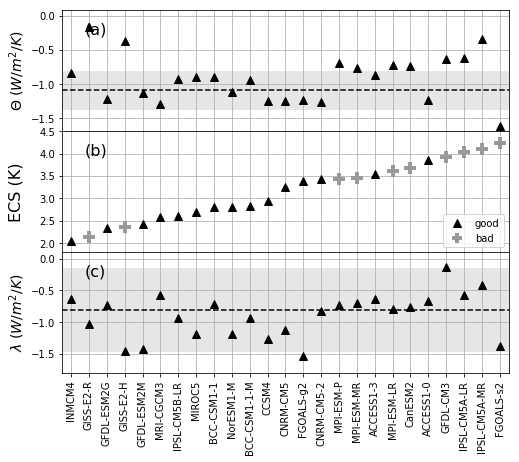

In [17]:
# sort models by ECS
mod2 = [k for k in sorted(ecs2, key=ecs2.get)]
    
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,8))
plt.subplots_adjust(bottom=0.25,hspace=0)

good=good_list.theta_detrended

# theta comparison
sca(axes[0])

low,high=np.percentile(slope_list.theta_detrended,5),np.percentile(slope_list.theta_detrended,95) # 5-95% uncertainty
avgceres=np.average(slope_list.theta_detrended)

for ii,vv in enumerate(mod2):
    plot([ii],feedbacks[vv]['piControl']['flux']['t_trop'],'k^',markersize=8)

fill_between([-100,100],low,high,color='0.9')
axhline(avgceres,color='k',ls='dashed')

plot(100,0,'k^',label='good',markersize=8)
plot(100,0,'k+',label='bad',markersize=10,mew=4,color='0.6')

gca().set_xticks(range(len(mod2)));
xlim(-0.5,len(mod2)-0.5)
# legend(loc=4)
grid()
ylabel(r'$\Theta$ ($W/m^2/K$)',fontsize=14)
# ylabel(r'$\Theta_{iv}$/$\Theta_{forced}$',fontsize=22)
gca().set_yticks([-1.5,-1,-0.5,0]);

# ECS
sca(axes[1])
goodECS=[]
for ii,vv in enumerate(mod2):
    if vv in good:
        plot([ii],ecs2[vv],'k^',markersize=8)
        goodECS.append(ecs2[vv])
    else:
        plot([ii],ecs2[vv],'+',color='0.6',markersize=12,mew=4)

ylim(1.8,4.5)
gca().set_yticks([2,2.5,3,3.5,4,4.5]);
        
xlim(-0.5,len(mod2)-0.5)
ylabel('ECS (K)',fontsize=16,labelpad=16)

gca().set_xticks(range(len(mod2)));
grid()

plot(100,0,'k^',label='good',markersize=8)
plot(100,0,'k+',label='bad',markersize=10,mew=4,color='0.6')
legend(loc=4)

# lambda comparison
sca(axes[2])

low,high=np.percentile(slope_list.lambda_detrended,5),np.percentile(slope_list.lambda_detrended,95) # 5-95% uncertainty
avgceres=np.average(slope_list.lambda_detrended)

for ii,vv in enumerate(mod2):
    plot([ii],feedbacks[vv]['piControl']['flux']['ts'],'k^',markersize=8)

fill_between([-100,100],low,high,color='0.9')
axhline(avgceres,color='k',ls='dashed')
xlim(-0.5,len(mod2)-0.5)
ylim(-1.8,0.1)
grid()

plot(100,0,'k^',label='good',markersize=8)
plot(100,0,'k+',label='bad',markersize=10,mew=4,color='0.6')
ylabel(r'$\lambda$ ($W/m^2/K$)',fontsize=14)
gca().set_yticks([-1.5,-1,-0.5,0]);
gca().set_xticks(range(len(mod2)));

sca(axes[2])

gca().set_xticks(range(len(mod2)));
gca().set_xticklabels(mod2,rotation='90');

for ii,ax in enumerate(axes):
#     ax.axvline(14.5,color='k')
    ax.text(0.05,[0.8,0.8,0.8][ii],'(a),(b),(c)'.split(',')[ii],fontsize=16,transform=ax.transAxes)

# savefig('fig7.eps')
# savefig('fig7')

print('average ECS of the good models: {:.2f}'.format(np.average(goodECS)))
print('std of {:.2f}'.format(np.std(goodECS)))
print('range of {:.2f} to {:.2f}'.format(np.min(goodECS),np.max(goodECS)))

## other stuff

### look at CERES regression of annual average values

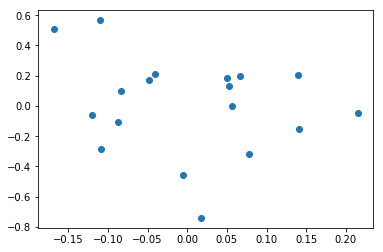

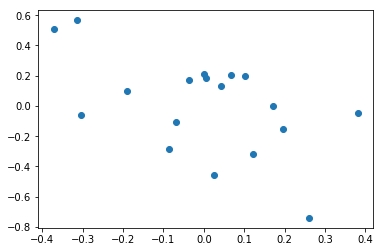

In [43]:
import xarray as xr, pandas as pd
import xradd

ceres1=xr.DataArray(CERESdetrendedFlux,dims='time',coords={'time': pd.date_range('2000-03-01',freq='M',
    periods=len(CERESdetrendedFlux))},name='flux')
ceres2=xr.DataArray(CERESdetrendedTa,dims='time',coords={'time': pd.date_range('2000-03-01',freq='M',
    periods=len(CERESdetrendedTa))},name='ta')
ceres3=xr.DataArray(CERESdetrendedTs,dims='time',coords={'time': pd.date_range('2000-03-01',freq='M',
    periods=len(CERESdetrendedTs))},name='ts')
ceres=xradd.annual(xr.merge([ceres1,ceres2,ceres3]))

figure()
plot(ceres.ts,ceres.flux,'o')
figure()
plot(ceres.ta,ceres.flux,'o')

In [41]:
## regression of flux vs. Ts
slope=monteCarlo1(np.array(ceres.ts),np.array(ceres.flux),runs=numSortRuns,autocorr=True)[0]
print('median: {:.2f}'.format(np.median(slope)))
print('5-95 percent confidence interval: {:.2f} to {:.2f}'.format(np.percentile(slope,5),np.percentile(slope,95)))

median: -0.70
5-95 percent confidence interval: -1.46 to 0.06


In [42]:
## regression of flux vs. Ta
slope=monteCarlo1(np.array(ceres.ta),np.array(ceres.flux),runs=numSortRuns,autocorr=True)[0]
print('median: {:.2f}'.format(np.median(slope)))
print('5-95 percent confidence interval: {:.2f} to {:.2f}'.format(np.percentile(slope,5),np.percentile(slope,95)))

median: -0.84
5-95 percent confidence interval: -1.36 to -0.33


Conclusion: using annual average in the $\lambda$ calculation gives an uncertainty about equal to using monthly average.  But using it in the $\Theta$ calculation gives a much larger uncertainty

LinregressResult(slope=-0.018490778438178007, intercept=-0.9837354919838726, rvalue=-0.028186573712292468, pvalue=0.8936051575964492, stderr=0.13673396294099832)


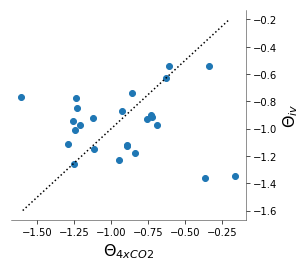

In [32]:
p1=np.array([feedbacks[ii]['piControl']['flux']['t_trop'] for ii in modname])
p2=np.array([feedbacks[ii]['abrupt4xCO2']['flux']['t_trop'] for ii in modname])
figure(figsize=(4.5,4))
plt.subplots_adjust(bottom=0.15,right=0.85)
plot(p1,p2,'o')
xlabel('$\Theta_{4xCO2}$',fontsize=16)
ylabel('$\Theta_{iv}$',fontsize=16)
one2one=np.linspace(-1.6,-0.2)
plot(one2one,one2one,'k',ls='dotted')
colorplotRight(gca())
print(stats.linregress(p1,p2))
savefig('corr')

average ECS of the good models: 2.90
std of 0.48
range of 2.04 to 3.86


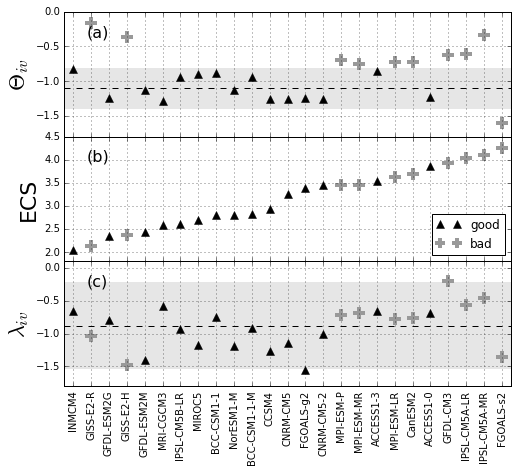

In [19]:
# sort models by p/a
mod2=[]
for key, value in sorted(ecs2.iteritems(), key=lambda (k,v): (v,k)):
    mod2.append(key)

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,8))
plt.subplots_adjust(bottom=0.25,hspace=0)

good=good_list.theta_detrended

# theta comparison
sca(axes[0])

low,high=np.percentile(slope_list.theta_detrended,5),np.percentile(slope_list.theta_detrended,95) # 5-95% uncertainty
avgceres=np.average(slope_list.theta_detrended)

for ii,vv in enumerate(mod2):
    if vv in good:
        plot([ii],feedbacks[vv]['piControl']['flux']['t_trop'],'k^',markersize=8)
    else:
        plot([ii],feedbacks[vv]['piControl']['flux']['t_trop'],'+',color='0.6',markersize=12,mew=4)

fill_between([-100,100],low,high,color='0.9')
axhline(avgceres,color='k',ls='dashed')

plot(100,0,'k^',label='good',markersize=8)
plot(100,0,'k+',label='bad',markersize=10,mew=4,color='0.6')

gca().set_xticks(range(len(mod2)));
xlim(-0.5,len(mod2)-0.5)
# legend(loc=4)
grid()
ylabel(r'$\Theta_{iv}$',fontsize=22)
# ylabel(r'$\Theta_{iv}$/$\Theta_{forced}$',fontsize=22)
gca().set_yticks([-1.5,-1,-0.5,0]);

# ECS
sca(axes[1])
goodECS=[]
for ii,vv in enumerate(mod2):
    if vv in good:
        plot([ii],ecs2[vv],'k^',markersize=8)
        goodECS.append(ecs2[vv])
    else:
        plot([ii],ecs2[vv],'+',color='0.6',markersize=12,mew=4)

ylim(1.8,4.5)
gca().set_yticks([2,2.5,3,3.5,4,4.5]);
        
xlim(-0.5,len(mod2)-0.5)
ylabel('ECS',fontsize=22)

gca().set_xticks(range(len(mod2)));
grid()

plot(100,0,'k^',label='good',markersize=8)
plot(100,0,'k+',label='bad',markersize=10,mew=4,color='0.6')
legend(loc=4)

# lambda comparison
sca(axes[2])

low,high=np.percentile(slope_list.lambda_detrended,5),np.percentile(slope_list.lambda_detrended,95) # 5-95% uncertainty
avgceres=np.average(slope_list.lambda_detrended)

for ii,vv in enumerate(mod2):
    if vv in good:
        plot([ii],feedbacks[vv]['piControl']['flux']['ts'],'k^',markersize=8)
    else:
        plot([ii],feedbacks[vv]['piControl']['flux']['ts'],'+',color='0.6',markersize=12,mew=4)

fill_between([-100,100],low,high,color='0.9')
axhline(avgceres,color='k',ls='dashed')
xlim(-0.5,len(mod2)-0.5)
ylim(-1.8,0.1)
grid()

plot(100,0,'k^',label='good',markersize=8)
plot(100,0,'k+',label='bad',markersize=10,mew=4,color='0.6')
ylabel(r'$\lambda_{iv}$',fontsize=22)
gca().set_yticks([-1.5,-1,-0.5,0]);
gca().set_xticks(range(len(mod2)));

sca(axes[2])

gca().set_xticks(range(len(mod2)));
gca().set_xticklabels(mod2,rotation='90');

for ii,ax in enumerate(axes):
#     ax.axvline(14.5,color='k')
    ax.text(0.05,[0.8,0.8,0.8][ii],'(a),(b),(c)'.split(',')[ii],fontsize=16,transform=ax.transAxes)
# if printf: 
#     savefig('Fig7.eps')
#     savefig('Fig7')

print 'average ECS of the good models: {:.2f}'.format(np.average(goodECS))
print 'std of {:.2f}'.format(np.std(goodECS))
print 'range of {:.2f} to {:.2f}'.format(np.min(goodECS),np.max(goodECS))

## plot $\Theta_{iv}$ vs. $\Theta_{4xCO2}$

In [31]:
## plot code
missing=object()
almost_black = '#262626' # tweek from Thorsten

def plotFeedbacks(p,a,modn,ax=missing,title=missing,era='t_trop',pspines=['left','bottom']):
    """plot piControl feedback vs. abrupt 4xCO2 feedback calculated from
    fluxvar vs. tempvar; era is a flat — if true, it plots ERAi feedback
    spines tells you where to put the axes [right/left,bottom/top]"""
           
    if ax is missing:
        figure(figsize=(9,7))
        ax=gca()

    ax.plot(p,a,'ko')
    
    invisible=set('left,top,right,bottom'.split(',')).difference(set(pspines))
    for spx in invisible:
        ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position(pspines[0])
    ax.xaxis.set_ticks_position(pspines[1])
    
    # set axis positions
    ax.yaxis.set_label_position(pspines[0]) 
    ax.xaxis.set_label_position(pspines[1]) 
    
    for spx in pspines:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)
        
    ax.plot(np.linspace(-5,5),np.linspace(-5,5),almost_black,ls='dotted')
#     ax.plot(np.linspace(-5,5),np.linspace(-5,5)*0.8,almost_black,ls='dotted')
#     ax.plot(np.linspace(-5,5),np.linspace(-5,5)*1.2,almost_black,ls='dotted')
    
    ax.tick_params(axis='both', which='major', labelsize=14)

    for ii,mn in enumerate(modn):
        ax.annotate('{}'.format(mn), (p[ii],a[ii]),fontsize=9)
    
    if title is missing:
        ax.set_title('{} {}'.format(fluxvar,tempvar),fontsize=16)
    else:
        ax.set_title(title,fontsize=16)
    
    if era != '':
        obs=erai['flux'][era]
        ax.axvline(obs.b[1],color='k',ls='dotted',lw=3)
        ax.fill_betweenx([-10,10],[obs.b[1]-obs.conf90[1],obs.b[1]-obs.conf90[1]],\
                      [obs.b[1]+obs.conf90[1],obs.b[1]+obs.conf90[1]],alpha=0.1,color='k')

#     ax.set_xlim(np.average(p)-1.1,np.average(p)+1.1)
#     ax.set_ylim(np.average(a)-1.1,np.average(a)+1.1)
#     xlim(-2,0.5)
#     ylim(-2,0.5)

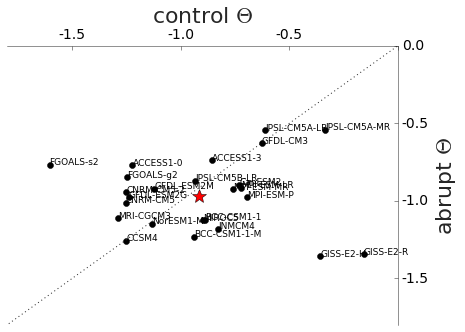

In [36]:
figure(figsize=(7,5))

good=good_list.theta_detrended
p=[feedbacks[vv]['piControl']['flux']['t_trop'] for vv in models]
a=[feedbacks[vv]['abrupt4xCO2']['flux']['t_trop'] for vv in models]

plotFeedbacks(p,a,models,ax=gca(),title='',era='',pspines=['right','top']) 

gca().set_xticks(np.arange(-2,0.5,0.5))
gca().set_xticklabels('-2.0,-1.5,-1.0,-0.5,'.split(','))
gca().set_yticks(np.arange(-2,0.5,0.5))
gca().set_yticklabels('-2.0,-1.5,-1.0,-0.5,0.0'.split(','))

xlim(-1.8,0)
ylim(-1.8,0)

xlabel('control $\Theta$',fontsize=22,color=almost_black)
ylabel('abrupt $\Theta$',fontsize=22,color=almost_black,rotation=90)

plot([np.average(p)],[np.average(a)],marker='*',color='r',markersize=14)
